In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import os
import numpy as np
import pywt
import math
import cv2
from random import sample
import random
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE

In [5]:
"""step1:对已经分段好的视频进行特征提取并保存"""
"""检测单张图片的角点特征坐标"""
def detect_feature(pic):
    feature_params = dict(maxCorners=500, qualityLevel=0.3, minDistance=7, blockSize=7)   # 参数设置
    mask = np.zeros_like(pic)  # 初始化和视频大小相同的图像
    mask[:] = 255  # 将mask赋值255也就是算全部图像的角点
    tracks = []   # 用于记录该图片的角点坐标
    p = cv2.goodFeaturesToTrack(pic,mask=mask,**feature_params)
    if p is not None:
        for x, y in np.float32(p).reshape(-1,2):
            tracks.append([(x,y)])
    return tracks

"""追踪5s检测角点的轨迹坐标并保存"""
def detect_track(video_input_path,box_coordinate_path,coordinate_path,feature_num_path):
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))  # 参数设置
    video = cv2.VideoCapture(video_input_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    track_len = 5*fps  # 每5s检测的轨迹长度
    frame_index = 0
    tracks = []  # 记录角点特征轨迹
    # 打开坐标文件
    with open(box_coordinate_path,"r") as f:
            line1 = f.readline().strip().replace("[","")
            line1 = line1.replace("]","")
            line1 = line1.split(",")
            box_coordinate = list(map(int,line1))
    
    # 对产生的坐标信息进行保存
    with open(feature_num_path,"w") as fw:
        while(video.isOpened()):
            ret, frame = video.read()   # 读取视频帧
            if ret == True:
                # 根据box大小剪裁视频
                frame = frame[box_coordinate[1]:box_coordinate[3],box_coordinate[0]:box_coordinate[2]]
                frame_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)  # 转化为灰度虚图像
                vis = frame.copy()

                # 储存写入每一帧tracks的特征角点数目
                fw.write(str(frame_index)+'\t')
                fw.write(str(len(tracks))+'\n')

                # 检测到角点后进行光流跟踪
                if len(tracks) > 0:
                    img0, img1 = pre_gray, frame_gray
                    p0 = np.float32([tr[-1] for tr in tracks]).reshape(-1,1,2)
                    p1, st, err = cv2.calcOpticalFlowPyrLK(img0,img1,p0,None,**lk_params) # 前一帧的角点和当前帧的图像作为输入来得到角点在当前帧的位置
                    p0r, st, err = cv2.calcOpticalFlowPyrLK(img1,img0,p1,None,**lk_params) # 当前帧跟踪到的角点和前一帧进行比较
                    dis = abs(p0-p0r).reshape(-1,2).max(-1)
                    good = dis < 1  # 判断d内的值是否小于1，大于1跟踪被认为是错误的跟踪点
                    new_tracks = []
                    # 将跟踪正确的点列入成功跟踪点
                    for tr, (x, y), good_flag in zip(tracks, p1.reshape(-1,2), good):
                        if not good_flag:
                            continue
                        tr.append((x,y))
                        if len(tr) > track_len+1:
                            print("too long")
                            del tr[0]
                        new_tracks.append(tr)  # 得到新的轨迹
                        cv2.circle(vis,(int(x),int(y)),2,(0,255,0),-1)  # 给角点坐标画圆
                    tracks = new_tracks
                    cv2.polylines(vis,[np.int32(tr) for tr in tracks],False,(0,0,255))  # 画变化轨迹
                    
                # 对首帧图像进行角点检测
                if frame_index == 0:
                    tracks = detect_feature(frame_gray)
                frame_index += 1
                pre_gray = frame_gray
                cv2.imshow('lk_track',vis)
                
            else:
                break
            ch = 0xFF & cv2.waitKey(1)
            if ch == 27:
                break

    with open(coordinate_path,'w') as f:
        # 进行格式修改
        tracks = [[list(xy) for xy in tr] for tr in tracks]
        # 写入前5s的轨迹坐标
        f.write(str(tracks)+ '\n')
        tracks = detect_feature(frame_gray)

In [3]:
def clip_cla():
    videos_dir = "./test"
    boxes_dir = "./检测框信息"
    coordinates_dir = "./轨迹坐标信息"
    features_dir = "./角点数目统计"
    for video_name in os.listdir(videos_dir):
        video_path = os.path.join(videos_dir,video_name)
        box_path = os.path.join(boxes_dir,video_name+".txt")
        coordinate_path = os.path.join(coordinates_dir,video_name)
        feature_path = os.path.join(features_dir,video_name)
        # 如果路径不存在则建立文件夹
        if not os.path.exists(coordinate_path):
            os.makedirs(coordinate_path)
        if not os.path.exists(feature_path):
            os.makedirs(feature_path)
        for clip_name in os.listdir(video_path):
            tmp_name = clip_name.split('.')[0]+".txt"
            clip_path = os.path.join(video_path,clip_name)
            clip_coordinate_path = os.path.join(coordinate_path,tmp_name)
            clip_feature_path = os.path.join(feature_path,tmp_name)
            detect_track(clip_path,box_path,clip_coordinate_path,clip_feature_path)
clip_cla()

In [6]:
"""step2:三类特征提取：坐标信息统计及每帧的特征角点数目统计,并进行小波变换"""
"""坐标信息统计：输入轨迹坐标文件，返回每个clip文件的轨迹移动距离"""
def dis_calculate(track_coordinate_path):
    with open(track_coordinate_path,"r") as f:
        line = f.readline()
        tracks = eval(line)
    feature_num = len(tracks)   
    tracks_sum = 0
    if feature_num == 0:
        return 0, 0
    for track in tracks:
        xy_num = len(track)
        track_sum = 0
        for i in range(xy_num-1):
            # 求相邻帧间角点坐标的距离，并累加
            dis = (track[i+1][0]-track[i][0])**2+(track[i+1][1]-track[i][1])**2
            track_sum += dis
        tracks_sum += track_sum
    average_dis = tracks_sum/feature_num
    return feature_num,average_dis

"""特征角点数目统计：输入特征角点数目文件，返回每个clip的帧数列表以及每帧的特征角点数目"""
def feature_num_cal(feature_num_path):
    frame_index_list = []
    feature_num_list = []
    with open(feature_num_path) as f:
        while True:
            line = f.readline()
            if not line:
                break
            line = line.split('\t')
            frame_index = eval(line[0])
            feature_num = eval(line[1])
            frame_index_list.append(frame_index)
            feature_num_list.append(feature_num)
    return frame_index_list, feature_num_list

"""小波变换：对clip视频进行小波变换"""
"""输入：每个clip的帧数列表以及每帧的特征角点数目；输出：每个clip的小波变换（25维向量）"""
def wtAnalysis(frame_index_list,feature_num_list):
    fps = int(len(frame_index_list)/5)
    # 进行小波变化
    cwtmatr, freqs = pywt.cwt(feature_num_list, np.arange(1, fps+1),'gaus8')  # cwtmart代表小波变换后每个时刻每个尺度下的幅度值
    # 对cwtmatr进行计算
    cwtmatr_array = np.array(cwtmatr)
    cwtmatr_sum = np.max(cwtmatr_array,axis=1)
    cwtmatr_sum = cwtmatr_sum.tolist()
    return cwtmatr_sum

In [7]:
"""三类特征统计数据保存"""
def store_feature():
    tracks_path = "./轨迹坐标信息"
    features_num_path = "./角点数目统计"
    stores_path = "./三类特征统计"
    for filename in sorted(os.listdir(tracks_path)):
        video_track_path = os.path.join(tracks_path,filename)
        if not os.path.exists(os.path.join(stores_path,filename)):
            os.makedirs(os.path.join(stores_path,filename))
        for clipname in sorted(os.listdir(video_track_path)):
            print("正在处理",filename,"-",clipname)
            tmp_path = filename+"/"+clipname
            clip_track_path = os.path.join(tracks_path,tmp_path)
            clip_feature_path = os.path.join(features_num_path,tmp_path)
            clip_store_path = os.path.join(stores_path,tmp_path)
            store_feature = []
            # 计算三类特征
            feature_num, average_dis = dis_calculate(clip_track_path)
            frame_index_list, feature_num_list = feature_num_cal(clip_feature_path)
            cwtmatr = wtAnalysis(frame_index_list,feature_num_list)
            # 保存三类特征：1.特征角点最终数目；2.轨迹坐标和；3.小波变换幅值
            store_feature = [feature_num,average_dis]+cwtmatr
            store_feature_array = np.array(store_feature)
            np.savetxt(clip_store_path,store_feature_array,delimiter=',',fmt='%.2f')
    print("所有数据已保存！")

In [109]:
# 绘制T-SNE图
def plot_tsne(data,label,color):
    tsne = TSNE(n_components=2,perplexity=10,random_state=0)  # ,perplexity=5, init="pca"
    tsne_obj = tsne.fit_transform(data)
    tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                           'Y':tsne_obj[:,1],
                           'digit':label})
    sns.scatterplot(x='X',y='Y',hue='digit',palette=color,legend='full',data=tsne_df)
    plt.show()

In [110]:
# 绘制不同分类方式的样本t-sne图
def t_sne_plt(clf_num):
    features_path = "./三类特征统计"
    labels_path = "./标签信息"
    score_save_path = os.path.join(os.path.join("./score数据统计",method),"class"+str(clf_num))
    feature_sample = [[],[],[],[]]
    filename_sample = [[],[],[],[]]
    for videoname in sorted(os.listdir(features_path)):
        video_feature_path = os.path.join(features_path,videoname)
        label_path = os.path.join(labels_path,videoname+".txt")
        # 读取标签文件
        label = []
        with open(label_path,"r",encoding='utf-8') as f:
            while True:
                line = f.readline()
                if not line:
                    break
                line = line.split('，')
                label.append(eval(line[1]))
        # 根据label读取每个clip的特征文件
        for i in range(len(label)):
            clipname = "clip"+str(i+1)+".txt"
            tmp_path = videoname+"/"+clipname
            clip_feature_path = os.path.join(video_feature_path,clipname)
            feature = np.loadtxt(clip_feature_path,delimiter=',')   # 读取feature文件
            feature_sample[label[i]-1].append(feature.tolist())
            filename_sample[label[i]-1].append(tmp_path)
    print("类别1样本数量：",len(feature_sample[0]),"类别1文件数量：",len(filename_sample[0]))
    print("类别2样本数量：",len(feature_sample[1]),"类别2文件数量：",len(filename_sample[1]))
    print("类别3样本数量：",len(feature_sample[2]),"类别3文件数量：",len(filename_sample[2]))
    print("类别4样本数量：",len(feature_sample[3]),"类别4文件数量：",len(filename_sample[3]))
    # 对样本数据集进行k折划分
    # 选择随机种子
    random.seed(0)
    if clf_num == 2:
        # 二分类
        feature_sample_array = sample(feature_sample[0],361)+feature_sample[1]+feature_sample[3]
        label_array = [0]*len(sample(feature_sample[0],361))+[1]*len(feature_sample[1]+feature_sample[3])
        filename_sample_array = sample(filename_sample[0],361)+filename_sample[1]+filename_sample[3]
        # 绘制 T-SNE图
        feature_sample_array = np.array(feature_sample_array)[:,0:2]
        feature_sample_array = preprocessing.scale(feature_sample_array)
        plot_tsne(feature_sample_array,label_array,['green','red'])
    elif clf_num == 3:
        # 三分类
        feature_sample_array = sample(feature_sample[0],159)+sample(feature_sample[1],159)+feature_sample[3]
        label_array = [0]*len(sample(feature_sample[0],159))+[1]*len(sample(feature_sample[1],159))+[2]*len(feature_sample[3])
        filename_sample_array = sample(filename_sample[0],159)+sample(filename_sample[1],159)+filename_sample[3]
        # 绘制 T-SNE图
        feature_sample_array = np.array(feature_sample_array)[:,0:2]
        feature_sample_array = preprocessing.scale(feature_sample_array)
        plot_tsne(feature_sample_array,label_array,['green','red','yellow'])
    elif clf_num == 4:
        # 四分类
        feature_sample_array = sample(feature_sample[0],104)+sample(feature_sample[1],104)+feature_sample[2]+sample(feature_sample[3],104)
        label_array = [0]*len(sample(feature_sample[0],104))+[1]*len(sample(feature_sample[1],104))+[2]*len(feature_sample[2])+[3]*len(sample(feature_sample[3],104))
        filename_sample_array = sample(filename_sample[0],104)+sample(filename_sample[1],104)+filename_sample[2]+sample(filename_sample[3],104)
        # 绘制 T-SNE图
        feature_sample_array = np.array(feature_sample_array)[:,0:2]
        feature_sample_array = preprocessing.scale(feature_sample_array)
        plot_tsne(feature_sample_array,label_array,['green','red','yellow','blue'])

类别1样本数量： 511 类别1文件数量： 511
类别2样本数量： 202 类别2文件数量： 202
类别3样本数量： 104 类别3文件数量： 104
类别4样本数量： 159 类别4文件数量： 159


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


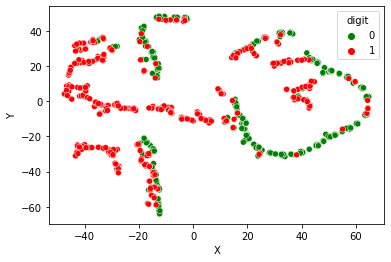

类别1样本数量： 511 类别1文件数量： 511
类别2样本数量： 202 类别2文件数量： 202
类别3样本数量： 104 类别3文件数量： 104
类别4样本数量： 159 类别4文件数量： 159


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


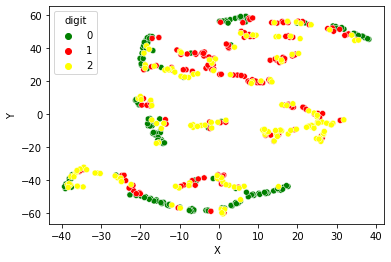

类别1样本数量： 511 类别1文件数量： 511
类别2样本数量： 202 类别2文件数量： 202
类别3样本数量： 104 类别3文件数量： 104
类别4样本数量： 159 类别4文件数量： 159


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


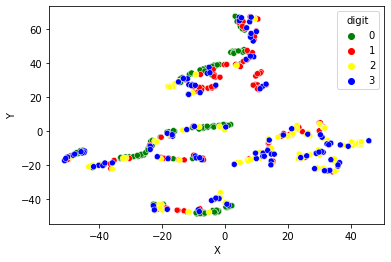

In [111]:
cls_num = [2,3,4]
for num in cls_num:
    t_sne_plt(num)

In [17]:
"""step3:选取样本，划分训练集和验证集，采用k折交叉验证的方式"""
"""利用svm，knn维分类器进行分类实验"""
def train_svm_knn(clf_num, method):
    features_path = "./三类特征统计"
    labels_path = "./标签信息"
    score_save_path = os.path.join(os.path.join("./score数据统计",method),"class"+str(clf_num))
    feature_sample = [[],[],[],[]]
    filename_sample = [[],[],[],[]]
    for videoname in sorted(os.listdir(features_path)):
        video_feature_path = os.path.join(features_path,videoname)
        label_path = os.path.join(labels_path,videoname+".txt")
        # 读取标签文件
        label = []
        with open(label_path,"r",encoding='utf-8') as f:
            while True:
                line = f.readline()
                if not line:
                    break
                line = line.split('，')
                label.append(eval(line[1]))
        # 根据label读取每个clip的特征文件
        for i in range(len(label)):
            clipname = "clip"+str(i+1)+".txt"
            tmp_path = videoname+"/"+clipname
            clip_feature_path = os.path.join(video_feature_path,clipname)
            feature = np.loadtxt(clip_feature_path,delimiter=',')   # 读取feature文件
            feature_sample[label[i]-1].append(feature.tolist())
            filename_sample[label[i]-1].append(tmp_path)
    print("类别1样本数量：",len(feature_sample[0]),"类别1文件数量：",len(filename_sample[0]))
    print("类别2样本数量：",len(feature_sample[1]),"类别2文件数量：",len(filename_sample[1]))
    print("类别3样本数量：",len(feature_sample[2]),"类别3文件数量：",len(filename_sample[2]))
    print("类别4样本数量：",len(feature_sample[3]),"类别4文件数量：",len(filename_sample[3]))
    # 对样本数据集进行k折划分
    # 选择随机种子
    random.seed(0)
    if clf_num == 2:
        # 二分类
        feature_sample_array = sample(feature_sample[0],361)+feature_sample[1]+feature_sample[3]
        label_array = [0]*len(sample(feature_sample[0],361))+[1]*len(feature_sample[1]+feature_sample[3])
        filename_sample_array = sample(filename_sample[0],361)+filename_sample[1]+filename_sample[3]
    elif clf_num == 3:
        # 三分类
        feature_sample_array = sample(feature_sample[0],159)+sample(feature_sample[1],159)+feature_sample[3]
        label_array = [0]*len(sample(feature_sample[0],159))+[1]*len(sample(feature_sample[1],159))+[2]*len(feature_sample[3])
        filename_sample_array = sample(filename_sample[0],159)+sample(filename_sample[1],159)+filename_sample[3]
    elif clf_num == 4:
        # 四分类
        feature_sample_array = sample(feature_sample[0],104)+sample(feature_sample[1],104)+feature_sample[2]+sample(feature_sample[3],104)
        label_array = [0]*len(sample(feature_sample[0],104))+[1]*len(sample(feature_sample[1],104))+[2]*len(feature_sample[2])+[3]*len(sample(feature_sample[3],104))
        filename_sample_array = sample(filename_sample[0],104)+sample(filename_sample[1],104)+filename_sample[2]+sample(filename_sample[3],104)
    feature_sample_array = np.array(feature_sample_array)
    # 选取数目特征和距离特征
#     feature_sample_array = np.array(feature_sample_array)[:,0:2]
    # 选取数目特征和小波特征
#     a = [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#     feature_sample_array = np.array(feature_sample_array)[:,a]
#     # 选取距离特征和小波特征
#     a = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#     feature_sample_array = np.array(feature_sample_array)[:,a]
    print("总样本数据维度：",feature_sample_array.shape)
    print("总样本标签维度：",label_array.shape)

    # 分层k折交叉验证
    skf = StratifiedKFold(n_splits=10)
    kindex = 0
    # 标签二值化
    classes = [[0,1],[0,1,2],[0,1,2,3]]
    # 储存每一轮的结果
    train_score_list = []
    test_score_list = []
    precision_score_list = []
    recall_score_list = []
    f1_score_list = []
#     feature_sample_array = preprocessing.scale(feature_sample_array)   # processing预处理
    for train, test in skf.split(filename_sample_array,label_array):
        train_data = np.array(feature_sample_array)[train,:]   # 划分好的训练集
        train_label = np.array(label_array)[train]
        test_data = np.array(feature_sample_array)[test,:]   # 划分好的测试集
        test_label = np.array(label_array)[test]
        if method == "SVM":
            # 利用svm进行多分类
            clf = svm.SVC(kernel='linear',decision_function_shape='ovr',max_iter=1e7,probability=True)
            clf.fit(train_data,train_label)
        if method == "KNN":
            clf = KNeighborsClassifier(n_neighbors=10)
            clf.fit(train_data,train_label)
        # 采用混淆矩阵计算各种评价指标
        predicted_train_label = clf.predict(train_data)
        predicted_test_label = clf.predict(test_data)
        predicted_test_score = clf.predict_proba(test_data)
#         np.save(os.path.join(score_save_path,method+"-predicted_train_label"+"-k"+str(kindex)),predicted_train_label)
#         np.save(os.path.join(score_save_path,method+"-true_train_label"+"-k"+str(kindex)),train_label)
#         np.save(os.path.join(score_save_path,method+"-predicted_test_label"+"-k"+str(kindex)),predicted_test_label)
#         np.save(os.path.join(score_save_path,method+"-true_test_label"+"-k"+str(kindex)),test_label)
#         np.save(os.path.join(score_save_path,method+"-predicted_test_score"+"-k"+str(kindex)),predicted_test_score)
#         print("当前折训练集准确率：",metrics.accuracy_score(train_label,predicted_train_label))
        train_score_list.append(metrics.accuracy_score(train_label,predicted_train_label))
#         print("当前折测试集准确率：",metrics.accuracy_score(test_label,predicted_test_label))
        test_score_list.append(metrics.accuracy_score(test_label,predicted_test_label))
#         print("当前折精准值：",metrics.precision_score(test_label,predicted_test_label,average='weighted'))
        precision_score_list.append(metrics.precision_score(test_label,predicted_test_label,average='weighted'))
#         print("当前折召回率：",metrics.recall_score(test_label,predicted_test_label,average='weighted'))
        recall_score_list.append(metrics.recall_score(test_label,predicted_test_label,average='weighted'))
#         print("当前折F1：",metrics.f1_score(test_label,predicted_test_label,average='weighted'))
        f1_score_list.append(metrics.f1_score(test_label,predicted_test_label,average='weighted'))
#         print("Done!*****************************************************")
        kindex += 1
        
    print("Method:",method," Clf_num",clf_num)
    print("训练集准确率：",np.array(train_score_list).mean())
    print("测试集准确率：",np.array(test_score_list).mean())
    print("精确率：",np.array(precision_score_list).mean())
    print("召回率：",np.array(recall_score_list).mean())
    print("F1得分：",np.array(f1_score_list).mean())

In [18]:
cls_num = [2,3,4]
methods = ["SVM","KNN"]
for num in cls_num:
    for method in methods:
        train_svm_knn(num,method)

类别1样本数量： 511 类别1文件数量： 511
类别2样本数量： 202 类别2文件数量： 202
类别3样本数量： 104 类别3文件数量： 104
类别4样本数量： 159 类别4文件数量： 159


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: The palette list has the wrong number of colors.

In [127]:
"""step3:选取样本，划分训练集和验证集，采用k折交叉验证的方式"""
"""利用mlp、rvm、random forest分类器进行分类实验"""
"""补充实验"""
def train_supplement(clf_num, method):
    features_path = "./三类特征统计"
    labels_path = "./标签信息"
    score_save_path = os.path.join(os.path.join("./score数据统计",method),"class"+str(clf_num))
    feature_sample = [[],[],[],[]]
    filename_sample = [[],[],[],[]]
    for videoname in sorted(os.listdir(features_path)):
        video_feature_path = os.path.join(features_path,videoname)
        label_path = os.path.join(labels_path,videoname+".txt")
        # 读取标签文件
        label = []
        with open(label_path,"r",encoding='utf-8') as f:
            while True:
                line = f.readline()
                if not line:
                    break
                line = line.split('，')
                label.append(eval(line[1]))
        # 根据label读取每个clip的特征文件
        for i in range(len(label)):
            clipname = "clip"+str(i+1)+".txt"
            tmp_path = videoname+"/"+clipname
            clip_feature_path = os.path.join(video_feature_path,clipname)
            feature = np.loadtxt(clip_feature_path,delimiter=',')   # 读取feature文件
            feature_sample[label[i]-1].append(feature.tolist())
            filename_sample[label[i]-1].append(tmp_path)
#     print("类别1样本数量：",len(feature_sample[0]),"类别1文件数量：",len(filename_sample[0]))
#     print("类别2样本数量：",len(feature_sample[1]),"类别2文件数量：",len(filename_sample[1]))
#     print("类别3样本数量：",len(feature_sample[2]),"类别3文件数量：",len(filename_sample[2]))
#     print("类别4样本数量：",len(feature_sample[3]),"类别4文件数量：",len(filename_sample[3]))
    # 对样本数据集进行k折划分
    # 选择随机种子
    random.seed(0)
    if clf_num == 2:
        # 二分类
        feature_sample_array = sample(feature_sample[0],361)+feature_sample[1]+feature_sample[3]
        label_array = [0]*len(sample(feature_sample[0],361))+[1]*len(feature_sample[1]+feature_sample[3])
        filename_sample_array = sample(filename_sample[0],361)+filename_sample[1]+filename_sample[3]
    elif clf_num == 3:
        # 三分类
        feature_sample_array = sample(feature_sample[0],159)+sample(feature_sample[1],159)+feature_sample[3]
        label_array = [0]*len(sample(feature_sample[0],159))+[1]*len(sample(feature_sample[1],159))+[2]*len(feature_sample[3])
        filename_sample_array = sample(filename_sample[0],159)+sample(filename_sample[1],159)+filename_sample[3]
    elif clf_num == 4:
        # 四分类
        feature_sample_array = sample(feature_sample[0],104)+sample(feature_sample[1],104)+feature_sample[2]+sample(feature_sample[3],104)
        label_array = [0]*len(sample(feature_sample[0],104))+[1]*len(sample(feature_sample[1],104))+[2]*len(feature_sample[2])+[3]*len(sample(feature_sample[3],104))
        filename_sample_array = sample(filename_sample[0],104)+sample(filename_sample[1],104)+filename_sample[2]+sample(filename_sample[3],104)
    feature_sample_array = np.array(feature_sample_array)
    label_array = np.array(label_array)
    # 选取数目特征和距离特征
#     feature_sample_array = np.array(feature_sample_array)[:,0:2]
    # 选取数目特征和小波特征
#     a = [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#     feature_sample_array = np.array(feature_sample_array)[:,a]
#     # 选取距离特征和小波特征
#     a = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#     feature_sample_array = np.array(feature_sample_array)[:,a]
    print("总样本数据维度：",feature_sample_array.shape)
    print("总样本标签维度：",label_array.shape)

    # 分层k折交叉验证
    skf = StratifiedKFold(n_splits=10)
    kindex = 0
    # 标签二值化
    classes = [[0,1],[0,1,2],[0,1,2,3]]
    # 储存每一轮的结果
    train_score_list = []
    test_score_list = []
    precision_score_list = []
    recall_score_list = []
    f1_score_list = []
#     feature_sample_array = preprocessing.scale(feature_sample_array)   # processing预处理
    for train, test in skf.split(filename_sample_array,label_array):
        train_data = np.array(feature_sample_array)[train,:]   # 划分好的训练集
        train_label = np.array(label_array)[train]
        test_data = np.array(feature_sample_array)[test,:]   # 划分好的测试集
        test_label = np.array(label_array)[test]
        if method == "MLP":
            # 利用mlp进行多分类
            from sklearn.neural_network import MLPClassifier
#             clf = MLPClassifier(solver='lbfgs',alpha=1e-6,hidden_layer_sizes=(64,3))
#             clf = MLPClassifier(solver='lbfgs',alpha=1e-6,hidden_layer_sizes=(128,6))
            clf = MLPClassifier(solver='lbfgs',alpha=1e-6,hidden_layer_sizes=(256,9))
            clf.fit(train_data,train_label)
        if method == "RVM":
            from sklearn_rvm import EMRVC
            clf = EMRVC(kernel='rbf',max_iter=10)
            clf.fit(train_data,train_label)
        if method == "RandomForest":
            from sklearn.ensemble import RandomForestClassifier
            clf = RandomForestClassifier(max_depth=2)
            clf.fit(train_data,train_label)
        # 采用混淆矩阵计算各种评价指标
        predicted_train_label = clf.predict(train_data)
        predicted_test_label = clf.predict(test_data)
        predicted_test_score = clf.predict_proba(test_data)
        np.save(os.path.join(score_save_path,method+"-predicted_train_label"+"-k"+str(kindex)),predicted_train_label)
        np.save(os.path.join(score_save_path,method+"-true_train_label"+"-k"+str(kindex)),train_label)
        np.save(os.path.join(score_save_path,method+"-predicted_test_label"+"-k"+str(kindex)),predicted_test_label)
        np.save(os.path.join(score_save_path,method+"-true_test_label"+"-k"+str(kindex)),test_label)
        np.save(os.path.join(score_save_path,method+"-predicted_test_score"+"-k"+str(kindex)),predicted_test_score)
        print("当前折训练集准确率：",metrics.accuracy_score(train_label,predicted_train_label))
        train_score_list.append(metrics.accuracy_score(train_label,predicted_train_label))
        print("当前折测试集准确率：",metrics.accuracy_score(test_label,predicted_test_label))
        test_score_list.append(metrics.accuracy_score(test_label,predicted_test_label))
#         print("当前折精准值：",metrics.precision_score(test_label,predicted_test_label,average='weighted'))
        precision_score_list.append(metrics.precision_score(test_label,predicted_test_label,average='weighted'))
#         print("当前折召回率：",metrics.recall_score(test_label,predicted_test_label,average='weighted'))
        recall_score_list.append(metrics.recall_score(test_label,predicted_test_label,average='weighted'))
#         print("当前折F1：",metrics.f1_score(test_label,predicted_test_label,average='weighted'))
        f1_score_list.append(metrics.f1_score(test_label,predicted_test_label,average='weighted'))
#         print("Done!*****************************************************")
        kindex += 1
        
    print("Method:",method," Clf_num",clf_num)
    print("训练集准确率：",np.array(train_score_list).mean())
    print("测试集准确率：",np.array(test_score_list).mean())
    print("精确率：",np.array(precision_score_list).mean())
    print("召回率：",np.array(recall_score_list).mean())
    print("F1得分：",np.array(f1_score_list).mean())

In [128]:
cls_num = [2,3,4]
methods = ["RVM"]
for num in cls_num:
    for method in methods:
        train_supplement(num,method)

总样本数据维度： (722, 27)
总样本标签维度： (722,)


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


当前折训练集准确率： 0.9352850539291218
当前折测试集准确率： 0.7671232876712328


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


当前折训练集准确率： 0.9352850539291218
当前折测试集准确率： 0.821917808219178


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


当前折训练集准确率： 0.9523076923076923
当前折测试集准确率： 0.8194444444444444


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\U

当前折训练集准确率： 0.9384615384615385
当前折测试集准确率： 0.875


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))


当前折训练集准确率： 0.9507692307692308
当前折测试集准确率： 0.7638888888888888


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))


当前折训练集准确率： 0.9384615384615385
当前折测试集准确率： 0.7638888888888888


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))


当前折训练集准确率： 0.9492307692307692
当前折测试集准确率： 0.6805555555555556


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


当前折训练集准确率： 0.9446153846153846
当前折测试集准确率： 0.8194444444444444


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


当前折训练集准确率： 0.9323076923076923
当前折测试集准确率： 0.8472222222222222


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))


当前折训练集准确率： 0.9476923076923077
当前折测试集准确率： 0.7222222222222222
Method: RVM  Clf_num 2
训练集准确率： 0.9424416261704396
测试集准确率： 0.7880707762557078
精确率： 0.7934332628340467
召回率： 0.7880707762557078
F1得分： 0.787088339186093
总样本数据维度： (477, 27)
总样本标签维度： (477,)


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0)

当前折训练集准确率： 0.9044289044289044
当前折测试集准确率： 0.5833333333333334


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0)

当前折训练集准确率： 0.9184149184149184
当前折测试集准确率： 0.5


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\An

当前折训练集准确率： 0.9207459207459208
当前折测试集准确率： 0.4166666666666667


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will c

当前折训练集准确率： 0.8974358974358975
当前折测试集准确率： 0.5625


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will c

当前折训练集准确率： 0.916083916083916
当前折测试集准确率： 0.5833333333333334


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will c

当前折训练集准确率： 0.9184149184149184
当前折测试集准确率： 0.5


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will c

当前折训练集准确率： 0.8997668997668997
当前折测试集准确率： 0.5


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in vers

当前折训练集准确率： 0.8953488372093024
当前折测试集准确率： 0.5106382978723404


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will c

当前折训练集准确率： 0.8906976744186047
当前折测试集准确率： 0.46808510638297873


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in vers

当前折训练集准确率： 0.9
当前折测试集准确率： 0.5957446808510638
Method: RVM  Clf_num 3
训练集准确率： 0.9061337886919283
测试集准确率： 0.5220301418439718
精确率： 0.5260835573657937
召回率： 0.5220301418439718
F1得分： 0.5027939068189571
总样本数据维度： (416, 27)
总样本标签维度： (416,)


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in vers

当前折训练集准确率： 0.9331550802139037
当前折测试集准确率： 0.42857142857142855


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in vers

当前折训练集准确率： 0.946524064171123
当前折测试集准确率： 0.6190476190476191


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will c

当前折训练集准确率： 0.9411764705882353
当前折测试集准确率： 0.5714285714285714


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will c

当前折训练集准确率： 0.9278074866310161
当前折测试集准确率： 0.42857142857142855


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in vers

当前折训练集准确率： 0.93048128342246
当前折测试集准确率： 0.5714285714285714


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in vers

当前折训练集准确率： 0.9385026737967914
当前折测试集准确率： 0.42857142857142855


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will c

当前折训练集准确率： 0.944
当前折测试集准确率： 0.4878048780487805


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in vers

当前折训练集准确率： 0.936
当前折测试集准确率： 0.5365853658536586


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in vers

当前折训练集准确率： 0.9386666666666666
当前折测试集准确率： 0.4146341463414634


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0))
C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn_rvm\em_rvm.py:581: RuntimeWarning: divide by zero encountered in log
  np.sum(np.log(1 - y[t == 0]), 0)

当前折训练集准确率： 0.9386666666666666
当前折测试集准确率： 0.4146341463414634
Method: RVM  Clf_num 4
训练集准确率： 0.9374980392156862
测试集准确率： 0.49012775842044143
精确率： 0.4773262357137059
召回率： 0.49012775842044143
F1得分： 0.46262540254080314


In [13]:
"""利用dt分类器进行分类实验"""
def train_dt(clf_num):
    features_path = "./三类特征统计"
    labels_path = "./标签信息"
    score_save_path = os.path.join(os.path.join("./score数据统计","DT"),"class"+str(clf_num))
    feature_sample = [[],[],[],[]]
    filename_sample = [[],[],[],[]]
    for videoname in sorted(os.listdir(features_path)):
        video_feature_path = os.path.join(features_path,videoname)
        label_path = os.path.join(labels_path,videoname+".txt")
        # 读取标签文件
        label = []
        with open(label_path,"r",encoding='utf-8') as f:
            while True:
                line = f.readline()
                if not line:
                    break
                line = line.split('，')
                label.append(eval(line[1]))
        # 根据label读取每个clip的特征文件
        for i in range(len(label)):
            clipname = "clip"+str(i+1)+".txt"
            tmp_path = videoname+"/"+clipname
            clip_feature_path = os.path.join(video_feature_path,clipname)
            feature = np.loadtxt(clip_feature_path,delimiter=',')   # 读取feature文件
            feature_sample[label[i]-1].append(feature.tolist())
            filename_sample[label[i]-1].append(tmp_path)
    print("类别1样本数量：",len(feature_sample[0]),"类别1文件数量：",len(filename_sample[0]))
    print("类别2样本数量：",len(feature_sample[1]),"类别2文件数量：",len(filename_sample[1]))
    print("类别3样本数量：",len(feature_sample[2]),"类别3文件数量：",len(filename_sample[2]))
    print("类别4样本数量：",len(feature_sample[3]),"类别4文件数量：",len(filename_sample[3]))
    # 对样本数据集进行k折划分
    # 选择随机种子
    random.seed(0)
    if clf_num == 2:
        # 二分类
        feature_sample_array = sample(feature_sample[0],361)+feature_sample[1]+feature_sample[3]
        label_array = [0]*len(sample(feature_sample[0],361))+[1]*len(feature_sample[1]+feature_sample[3])
        filename_sample_array = sample(filename_sample[0],361)+filename_sample[1]+filename_sample[3]
    elif clf_num == 3:
        # 三分类
        feature_sample_array = sample(feature_sample[0],159)+sample(feature_sample[1],159)+feature_sample[3]
        label_array = [0]*len(sample(feature_sample[0],159))+[1]*len(sample(feature_sample[1],159))+[2]*len(feature_sample[3])
        filename_sample_array = sample(filename_sample[0],159)+sample(filename_sample[1],159)+filename_sample[3]
    elif clf_num == 4:
        # 四分类
        feature_sample_array = sample(feature_sample[0],104)+sample(feature_sample[1],104)+feature_sample[2]+sample(feature_sample[3],104)
        label_array = [0]*len(sample(feature_sample[0],104))+[1]*len(sample(feature_sample[1],104))+[2]*len(feature_sample[2])+[3]*len(sample(feature_sample[3],104))
        filename_sample_array = sample(filename_sample[0],104)+sample(filename_sample[1],104)+filename_sample[2]+sample(filename_sample[3],104)
# #     feature_sample_array = feature_sample_array[:,0:2]
#     # 选取数目特征和小波特征
# #     a = [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
# #     feature_sample_array = feature_sample_array[:,a]
#     # 选取距离特征和小波特征
# #     a = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
# #     feature_sample_array = feature_sample_array[:,a]
#     print("总样本数据维度：",feature_sample_array.shape)
#     print("总样本标签维度：",label_array.shape)

    # 分层k折交叉验证
    skf = StratifiedKFold(n_splits=10)
    kindex = 0
    # 标签二值化
    classes = [[0,1],[0,1,2],[0,1,2,3]]
    # 储存每一轮的结果
    train_score_list = []
    test_score_list = []
    precision_score_list = []
    recall_score_list = []
    f1_score_list = []
#     feature_sample_array = preprocessing.scale(feature_sample_array)   # processing预处理
    for train, test in skf.split(filename_sample_array,label_array):
        train_data = np.array(feature_sample_array)[train,:]   # 划分好的训练集
        train_label = np.array(label_array)[train]
        test_data = np.array(feature_sample_array)[test,:]   # 划分好的测试集
        test_label = np.array(label_array)[test]
        
        clf = DecisionTreeClassifier(random_state=0,max_depth=3)
        clf.fit(train_data,train_label)
        
        # 采用混淆矩阵计算各种评价指标
        predicted_train_label = clf.predict(train_data)
        predicted_test_label = clf.predict(test_data)
        predicted_test_score = clf.predict_proba(test_data)
        np.save(os.path.join(score_save_path,"DT-predicted_train_label"+"-k"+str(kindex)),predicted_train_label)
        np.save(os.path.join(score_save_path,"DT-true_train_label"+"-k"+str(kindex)),train_label)
        np.save(os.path.join(score_save_path,"DT-predicted_test_label"+"-k"+str(kindex)),predicted_test_label)
        np.save(os.path.join(score_save_path,"DT-true_test_label"+"-k"+str(kindex)),test_label)
        np.save(os.path.join(score_save_path,"DT-predicted_test_score"+"-k"+str(kindex)),predicted_test_score)
#         print("当前折训练集准确率：",metrics.accuracy_score(train_label,predicted_train_label))
        train_score_list.append(metrics.accuracy_score(train_label,predicted_train_label))
#         print("当前折测试集准确率：",metrics.accuracy_score(test_label,predicted_test_label))
        test_score_list.append(metrics.accuracy_score(test_label,predicted_test_label))
#         print("当前折精准值：",metrics.precision_score(test_label,predicted_test_label,average='weighted'))
        precision_score_list.append(metrics.precision_score(test_label,predicted_test_label,average='weighted'))
#         print("当前折召回率：",metrics.recall_score(test_label,predicted_test_label,average='weighted'))
        recall_score_list.append(metrics.recall_score(test_label,predicted_test_label,average='weighted'))
#         print("当前折F1：",metrics.f1_score(test_label,predicted_test_label,average='weighted'))
        f1_score_list.append(metrics.f1_score(test_label,predicted_test_label,average='weighted'))
#         print("Done!*****************************************************")
        kindex += 1
        
    print(" Clf_num",clf_num)
    print("训练集准确率：",np.array(train_score_list).mean())
    print("测试集准确率：",np.array(test_score_list).mean())
    print("精确率：",np.array(precision_score_list).mean())
    print("召回率：",np.array(recall_score_list).mean())
    print("F1得分：",np.array(f1_score_list).mean())

In [14]:
cls_num = [2,3,4]
for num in cls_num:
    train_dt(num)

类别1样本数量： 511 类别1文件数量： 511
类别2样本数量： 202 类别2文件数量： 202
类别3样本数量： 104 类别3文件数量： 104
类别4样本数量： 159 类别4文件数量： 159
 Clf_num 2
训练集准确率： 0.8879651534905773
测试集准确率： 0.86837899543379
精确率： 0.8781385126371818
召回率： 0.86837899543379
F1得分： 0.8674672986270892
类别1样本数量： 511 类别1文件数量： 511
类别2样本数量： 202 类别2文件数量： 202
类别3样本数量： 104 类别3文件数量： 104
类别4样本数量： 159 类别4文件数量： 159
 Clf_num 3
训练集准确率： 0.7090654306933377
测试集准确率： 0.5931737588652484
精确率： 0.6029276892349664
召回率： 0.5931737588652484
F1得分： 0.5832080493458174
类别1样本数量： 511 类别1文件数量： 511
类别2样本数量： 202 类别2文件数量： 202
类别3样本数量： 104 类别3文件数量： 104
类别4样本数量： 159 类别4文件数量： 159
 Clf_num 4
训练集准确率： 0.6068484848484849
测试集准确率： 0.5265389082462253
精确率： 0.5420268869177345
召回率： 0.5265389082462253
F1得分： 0.5222434694304627


C:\Users\admin\Anaconda3\envs\UEX\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
